In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

sys.path.append("..")
from utils.util_functions import *

# 流れがいい時だけ取り出して得点の分散との関係を見る

In [ ]:
def is_improved(before, after):
    if before[0] == after[0]:
        if int(before[::-1][:-1]) <= int(after[::-1][:-1]):
            return True
    return False

def is_deteriorated(before, after):
    if int(before[0]) < int(after):
        if int(before[::-1][:-1]) >= int(after[::-1][:-1]):
            return True
    return False

In [2]:
event_df = make_df("20180101", "20181231")

In [ ]:
team = "ロッテ"
lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))

In [ ]:
def digits_to_list(case):
    res = [0] * 6
    out = case[0]
    if out != "3":
        res[int(out)] = 1
    if case[1] == "1":
        res[3] = 1
    if case[2] == "1":
        res[4] = 1
    if case[3] == "1":
        res[5] = 1
    return res

In [ ]:
digits_to_list("1001")

In [ ]:
def make_data_set(lst):
    data = []
    for triple in lst:
        st0, st1, st2 = triple
        feature = digits_to_list(st0) + digits_to_list(st1)
        label = digits_to_list(st2)
        data.append([feature, label])
    return data

In [ ]:
data = make_data_set(lst)

In [ ]:
X = np.array(np.array(data)[:, 0].tolist())
y = np.array(np.array(data)[:, 1].tolist())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, cohen_kappa_score

In [ ]:
num = 1

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train[:, num])

In [ ]:
model.coef_

In [ ]:
sum(model.predict(X_test) == y_test[:, num]) / len(y_test)

In [ ]:
confusion_matrix(model.predict(X_test), y_test[:, num])

In [ ]:
cohen_kappa_score(model.predict(X_test), y_test[:, num])

In [ ]:
team = "ロッテ"
lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))

In [ ]:
improved_lst = [elem for elem in lst if is_improved(elem[0], elem[1])]

In [ ]:
len(improved_lst), len(lst)

In [ ]:
second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)

In [ ]:
second_cond_entropy

In [ ]:
first_cond_entropy

In [3]:
column = "得点"

In [4]:
diffs = []
stds = []
for team in pacific+central:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    #improved_lst = [elem for elem in lst if is_improved(elem[0], elem[1])]
    improved_lst = [elem for elem in lst if is_deteriorated(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df(team).describe()[column]["std"] #/ make_score_df(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

西武 -0.10179032068968841 3.46452910947
ソフトバンク -0.089414622760289 3.19062218542
日本ハム -0.08400378484355508 2.99808120277
オリックス -0.09048961809240619 2.86439522962
ロッテ -0.09913591208737693 2.72549398464
楽天 -0.08917703771208685 2.87909948565
広島 -0.10434874360639457 3.1490932408
ヤクルト -0.09155922865863175 2.91726519115
巨人 -0.07710201629454327 3.27865168571
ＤｅＮＡ -0.07286362780178757 2.79709599974
中日 -0.09488352933846134 2.9345880116
阪神 -0.0876222136286986 3.62989803137


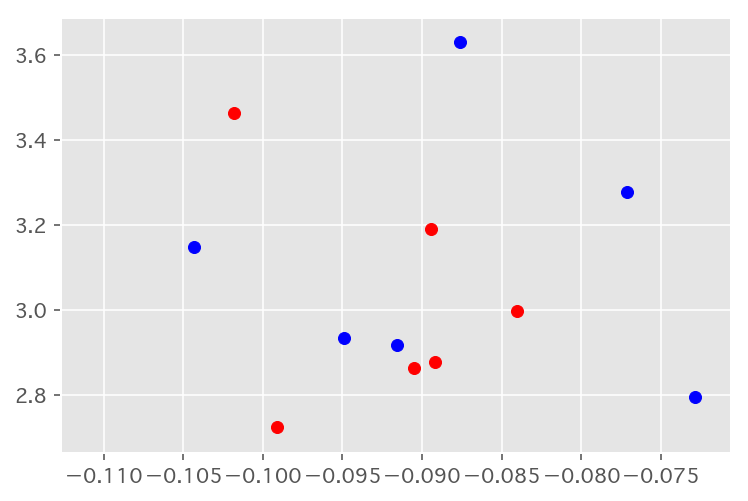

In [5]:
plt.scatter(diffs[:6], stds[:6], color="red")
plt.scatter(diffs[6:], stds[6:], color="blue")

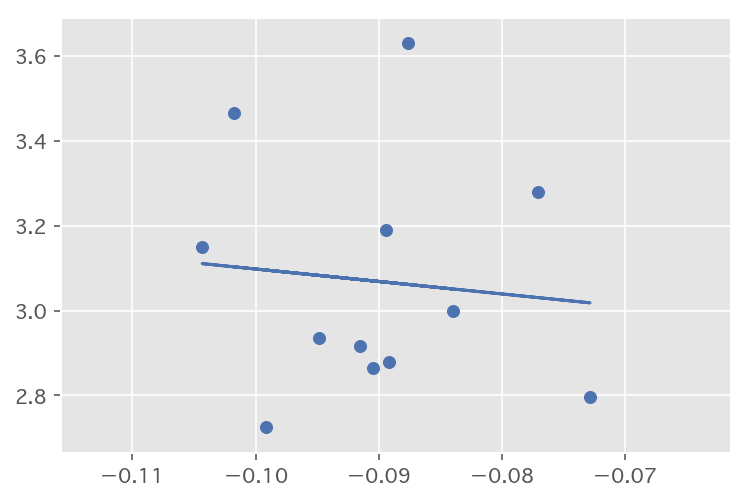

In [6]:
import statsmodels.api as sm

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.show()

In [7]:
results.pvalues

array([ 0.00809077,  0.76069986])

# MLB

In [ ]:
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
res = []
for file in files:
    res.append(pd.read_csv(os.path.join(DETAIL_DATA_DIR_MLB, file), encoding="cp932", dtype=str).values.tolist())

In [ ]:
inning_list = []
for elem in res:
    try:
        inning_list.append(np.array(elem)[:, 1].tolist() + ["GAMESET"])
    except:
        print("ng")

In [8]:
event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)

In [ ]:
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")

In [ ]:
"""def make_score_df_mlb(team):
    res = []
    columns = ["相手", "得点", "失点"]
    df = pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0)
    df_top = df[df["表チーム"]==team]
    df_bot = df[df["裏チーム"]==team]
    for elem in df_top.values:
        res.append([elem[1], elem[2], elem[3]])
    for elem in df_bot.values:
        res.append([elem[0], elem[3], elem[2]])
    return pd.DataFrame(res, columns=columns)"""

In [ ]:
diffs = []
stds = []
for team in teams_mlb:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    improved_lst = [elem for elem in lst if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    std = make_score_df_mlb(team).describe()[column]["std"] / make_score_df_mlb(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

アストロズ -0.07002998302764718 0.684975274055
レンジャーズ -0.08768508268172637 0.714067340083
ブリュワーズ -0.07547572526071189 0.670083659328
ロッキーズ -0.0729843569532238 0.6973869369
マーリンズ -0.08602634396039033 0.745161351662
エンゼルス -0.07161647836365015 0.692139970806
ジャイアンツ -0.08098646435742474 0.737955073316
Dバックス -0.08169983095402245 0.708102395369
ブレーブス -0.08315309778553459 0.70938418131
ロイヤルズ -0.07473927699379646 0.757228903468
ツインズ -0.07334575888129669 0.649470212774
パドレス -0.07762289288740254 0.668453678081
ブルージェイズ -0.07927777352135612 0.666022782951
ドジャース -0.07226038015622471 0.697131500955
Rソックス -0.07997286448271801 0.669210021299
メッツ -0.06713829108721425 0.735159694044
カージナルス -0.08090705754474259 0.668960338682
ナショナルズ -0.07169169869566883 0.795189195443
アスレチックス -0.06518569477223801 0.640292515595
マリナーズ -0.07216476315211118 0.668948069586
レイズ -0.06608716381612556 0.70014369491
パイレーツ -0.07452107769433924 0.713864249192
レッズ -0.08028185490385153 0.678095136226
カブス -0.07881846393753245 0.76322467251

In [ ]:
plt.scatter(diffs, stds)

In [ ]:
import statsmodels.api as sm

nsample = len(diffs)
X = np.column_stack((np.repeat(1, nsample), diffs))

model = sm.OLS(stds, X)
results = model.fit()

a, b = results.params

plt.scatter(diffs, stds)
plt.plot(diffs, a+b*np.array(diffs))
plt.show()

In [ ]:
results.pvalues

# 流れでエントロピーの差を見る

In [ ]:
diffs = []
stds = []
for team in teams_mlb:
    print("====="+team+"=====")
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    improved_lst = [elem for elem in lst if is_improved(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    print("いい流れ : "+str(first_cond_entropy - second_cond_entropy))
    improved_lst = [elem for elem in lst if is_deteriorated(elem[0], elem[1])]
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(improved_lst)[2].values, pd.DataFrame(improved_lst)[[1]].values)
    print("悪い流れ : "+str(first_cond_entropy - second_cond_entropy))